## Importing libraries

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Helper functions and classes

We create a dense neural network module with a leaky ReLU activation function. We can specify the number of nodes in each layer later.

In [2]:
class MLP(nn.Module):
  def __init__(self, layers):
    super().__init__()
    
    linear_modules = [nn.Linear(x,y) for x,y in zip(layers[:-1], layers[1:])]
    self.layers = nn.ModuleList(linear_modules)
  
  def forward(self, x):
    activation = nn.LeakyReLU()
    for layer in self.layers:
      x = activation(layer(x))
    
    return x

We train the model until it reaches an MSE of $0.01$ or less. If it does not reach this threshold after some pre-determined maximum number of epochs, we stop training.

Accuracy is calculated by rounding the predictions to the nearest integer and comparing it with the correct answer.

In [3]:
def train(model, dataX, dataY, max_epochs, learning_rate, verbose=True):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  mse = float('inf')
  epoch = 0
  while mse > 0.01 and epoch < max_epochs:
    outputs = model.forward(dataX)
    optimizer.zero_grad()
    loss = criterion(outputs, dataY)
    loss.backward()
    optimizer.step()
    
    if verbose or epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    epoch += 1
    mse = loss.item()
  
  return epoch, mse

def test(model, dataX, dataY):
  model.eval()
  predictions = model(dataX)

  dataY = dataY.numpy().astype(int)
  predictions = (predictions.detach().numpy()+0.5).astype(int)
  
  acc = 0
  for x,y in zip(predictions, dataY):
    acc += all(x == y)
  acc /= len(dataX)

  return acc

We keep track of the number of epochs it took to train the neural network, its final MSE, and its final accuracy.

In [4]:
def run(N, dir, layers, max_epoch, learning_rate, verbose=True):
  df = pd.read_csv(f"data/{dir}/perm{N}.csv")
  dataX = torch.Tensor(df.iloc[:,:N].values)
  dataY = torch.Tensor(df.iloc[:,N:].values)

  model = MLP([N]+layers+[N])
  epoch, train_mse = train(model, dataX, dataY, max_epoch, learning_rate, verbose)
  acc = test(model, dataX, dataY)

  return epoch, train_mse, acc

## Testing Proper

We declare some hyperparameters, and train a DNN with there hyperparameters.

In [5]:
# Trains all sizes for 4 to N inclusive
N = 7

# List of bounds to train
TO_TRAIN = ["2swap", "nswap", "3swap", "2insert", "ninsert", "3insert", "2reverse", "nreverse", "3reverse"]

# Number of nodes in the hidden layers of the DNN
LAYERS = [300, 300, 300]

# Maximum number of epochs before training stops immediately
MAX_EPOCH = 10000

# DNN learning rate
LEARNING_RATE = 0.01                                                          

# Stores results
RESULTS = []

In [6]:
for i,dir in enumerate(TO_TRAIN):
  tmp_results = []
  for n in range(4,N+1):
    epoch, train_mse, acc = run(n, dir, LAYERS, MAX_EPOCH, LEARNING_RATE, False)
    tmp_results.append((n, epoch, train_mse, acc))
    print(f"{dir} - Size: {n}, epochs: {epoch},  MSE: {train_mse:.4f}, accuracy: {acc:.4f}")
  RESULTS.append(tmp_results)
  

Epoch: 0, loss: 7.44620
Epoch: 100, loss: 0.01258
2swap - Size: 4, epochs: 103,  MSE: 0.0093, accuracy: 1.0000
Epoch: 0, loss: 10.31429
Epoch: 100, loss: 0.03373
2swap - Size: 5, epochs: 122,  MSE: 0.0096, accuracy: 1.0000
Epoch: 0, loss: 14.84155
Epoch: 100, loss: 0.07217
2swap - Size: 6, epochs: 184,  MSE: 0.0099, accuracy: 0.9889
Epoch: 0, loss: 19.41441
Epoch: 100, loss: 0.39417
Epoch: 200, loss: 0.05601
Epoch: 300, loss: 0.01792
Epoch: 400, loss: 0.01471
2swap - Size: 7, epochs: 406,  MSE: 0.0096, accuracy: 0.9944
Epoch: 0, loss: 7.26750
Epoch: 100, loss: 0.14604
nswap - Size: 4, epochs: 152,  MSE: 0.0097, accuracy: 1.0000
Epoch: 0, loss: 10.61835
Epoch: 100, loss: 0.44053
Epoch: 200, loss: 0.01516
nswap - Size: 5, epochs: 217,  MSE: 0.0092, accuracy: 0.9832
Epoch: 0, loss: 15.10120
Epoch: 100, loss: 0.14904
Epoch: 200, loss: 0.03078
Epoch: 300, loss: 0.01328
nswap - Size: 6, epochs: 357,  MSE: 0.0098, accuracy: 0.9819
Epoch: 0, loss: 19.39391
Epoch: 100, loss: 0.77600
Epoch: 200,

We can visualize our results for clearer insights.

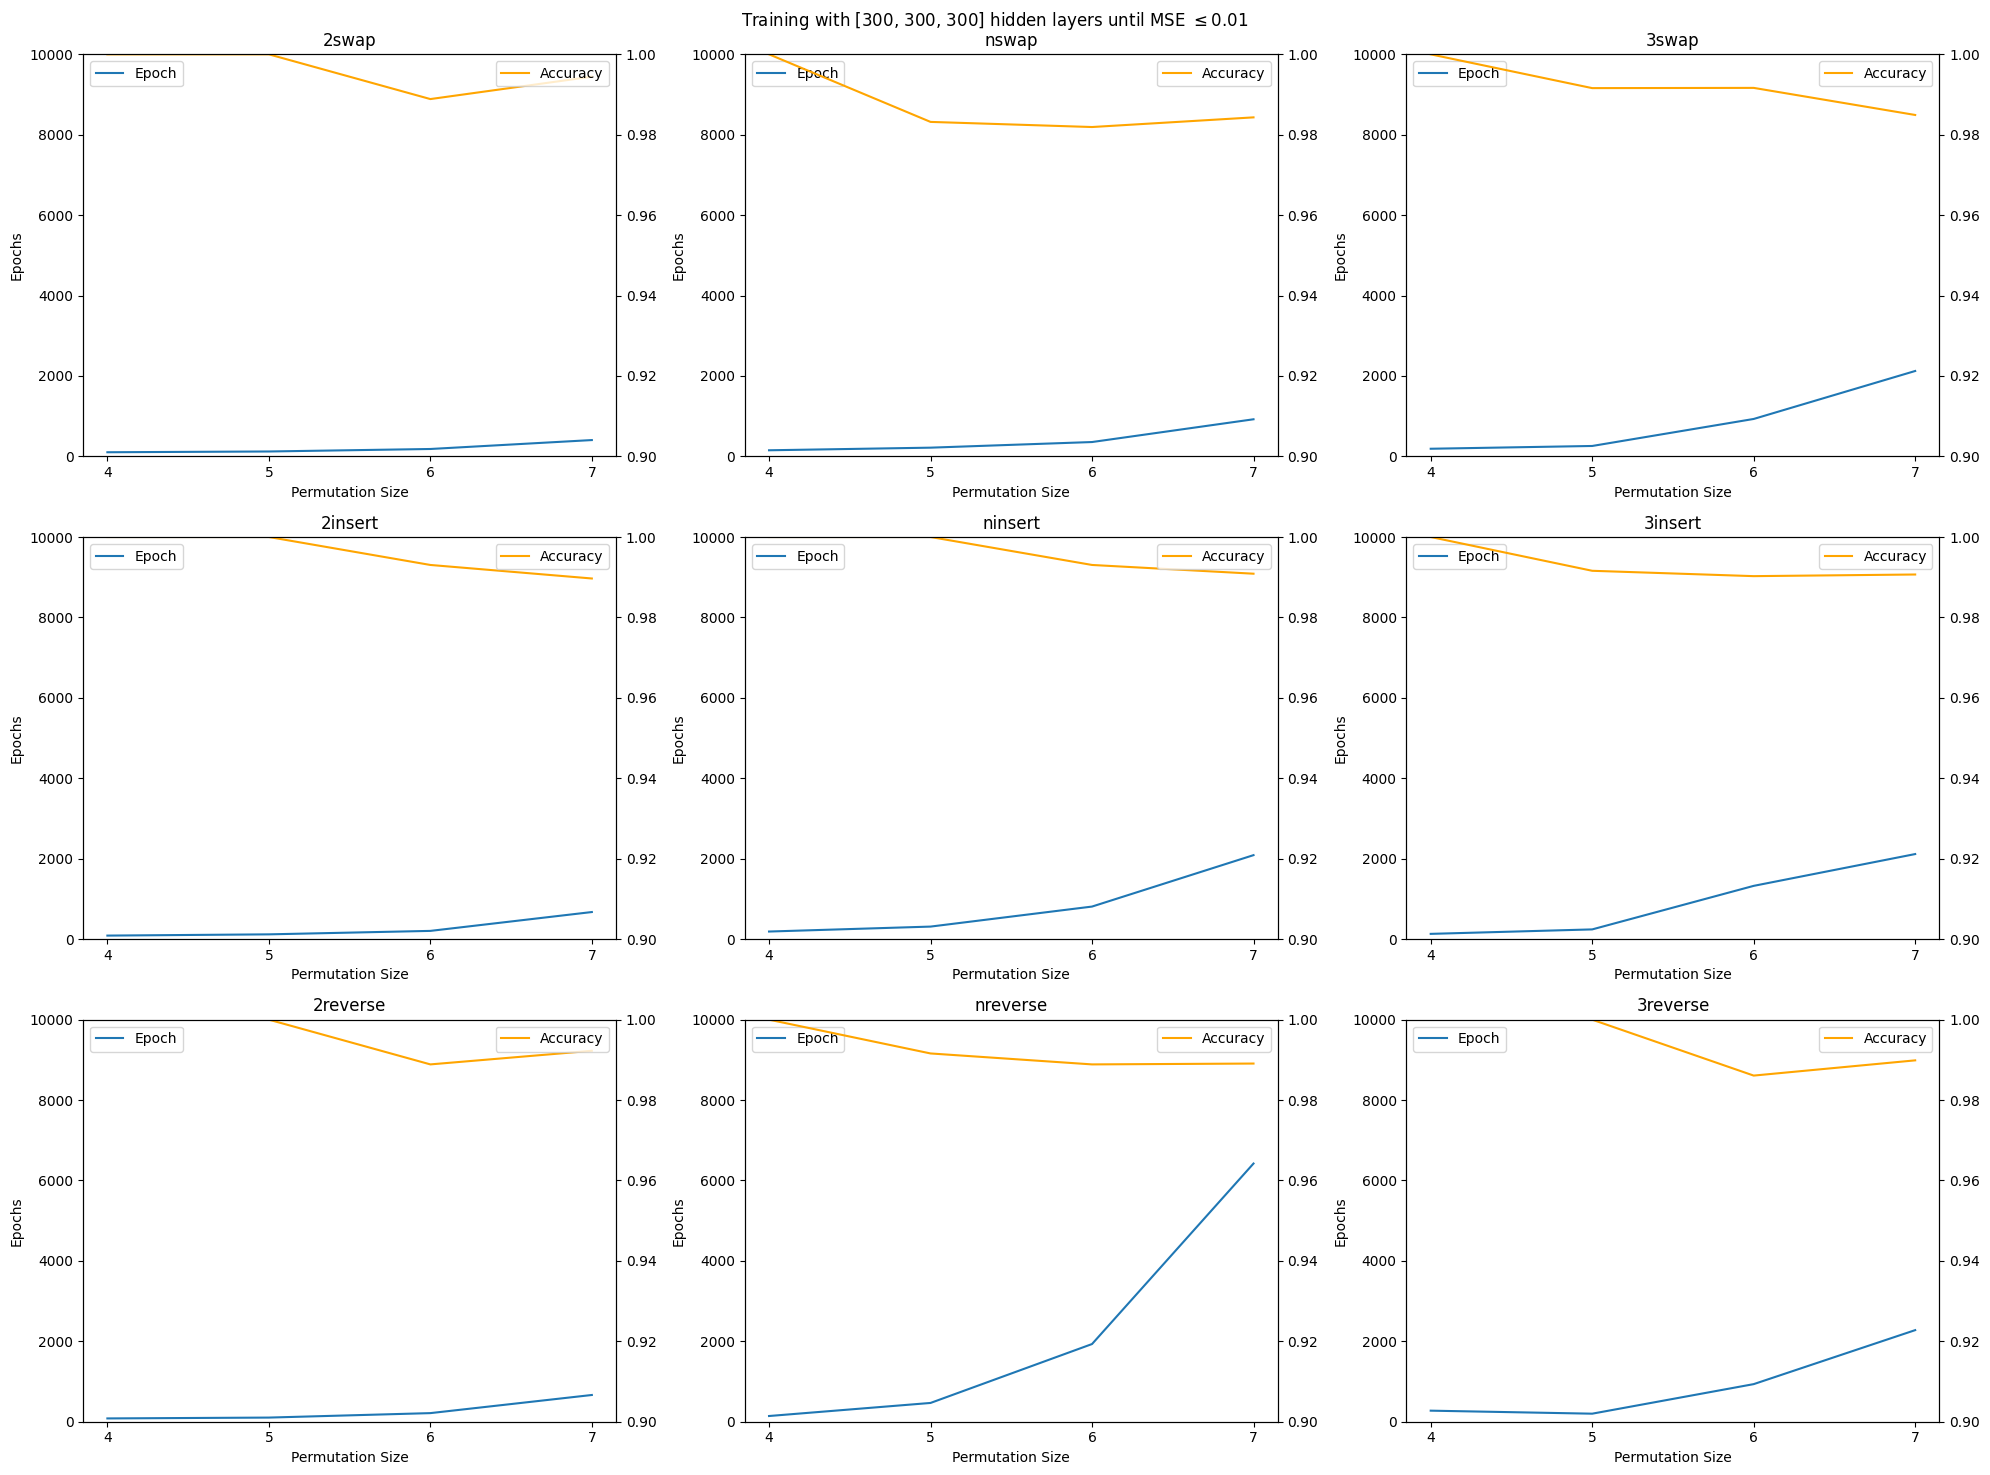

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(20,15))
for i,ax in enumerate(axes.flatten()[:len(TO_TRAIN)]):
  ax.plot(range(4,N+1), np.array([x[1] for x in RESULTS[i]]), label="Epoch")
  
  acc_ax = ax.twinx()
  acc_ax.plot(range(4, N+1), [x[3] for x in RESULTS[i]], label="Accuracy", color="orange")
  acc_ax.set_ylim(0.9,1)

  ax.set_ylim(0,MAX_EPOCH)
  ax.set_xticks(range(4, N+1))
  
  ax.set_title(TO_TRAIN[i])
  ax.set_xlabel("Permutation Size")
  ax.set_ylabel("Epochs")

  ax.legend(loc="upper left")
  acc_ax.legend(loc="upper right")

fig.suptitle(f"Training with {LAYERS} hidden layers until MSE $\leq 0.01$")
fig.tight_layout()

We save our results into a `.csv` file. If some results already exist, we simply update it.

In [8]:
to_df = []
for name, results in zip (TO_TRAIN, RESULTS):
  for size, epoch, mse, acc in results:
    to_df.append([name, size, epoch, mse, acc])
df = pd.DataFrame(to_df, columns=["name", "size", "epochs", "mse", "accuracy"])
df.head()

,name,size,epochs,mse,accuracy
0,2swap,4,103,0.009292,1.000000
1,2swap,5,122,0.009565,1.000000
2,2swap,6,184,0.009925,0.988873
3,2swap,7,406,0.009605,0.994443
4,nswap,4,152,0.009720,1.000000


In [9]:
results_name = "epoch-results.csv"
if not os.path.isfile(results_name):
  df.to_csv(results_name, index=False)

current_df = pd.read_csv(results_name)
to_extend = []
for i, row in df.iterrows():
  query_res = current_df.query(f"name==\"{row['name']}\" and size=={row['size']}")
  if len(query_res) > 0:
    current_df.iloc[query_res.index[0]] = row
  else:
    to_extend.append(row)

extended_df = pd.concat([current_df, pd.DataFrame(to_extend)], ignore_index=True)
extended_df.to_csv(results_name, index=False)
extended_df

,name,size,epochs,mse,accuracy
0,2swap,4,103,0.009292,1.000000
1,2swap,5,122,0.009565,1.000000
2,2swap,6,184,0.009925,0.988873
3,2swap,7,406,0.009605,0.994443
4,nswap,4,152,0.009720,1.000000
5,nswap,5,217,0.009230,0.983193
6,nswap,6,357,0.009812,0.981919
7,nswap,7,923,0.009868,0.984322
8,3swap,4,190,0.009353,1.000000
9,3swap,5,259,0.009546,0.991597
